In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statannotations.Annotator import Annotator

import gseapy as gp
from gseapy import barplot, dotplot

In [2]:
print(sc.__version__)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(mpl.__version__)
print(gp.__version__)


1.9.1
1.23.5
1.5.2
0.11.2
3.6.2
1.0.3


In [3]:
path = '/Users/busracagirici/Downloads/'
table_path = '/Users/busracagirici/Downloads/'
figure_path = '/Users/busracagirici/Downloads/'

adata = sc.read_h5ad(path+'GSE272840_ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [4]:
filtered =adata[adata.obs.high_quality=='True']
filtered

View of AnnData object with n_obs × n_vars = 20672 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()
filtered.layers['raw'] = filtered.X.copy()

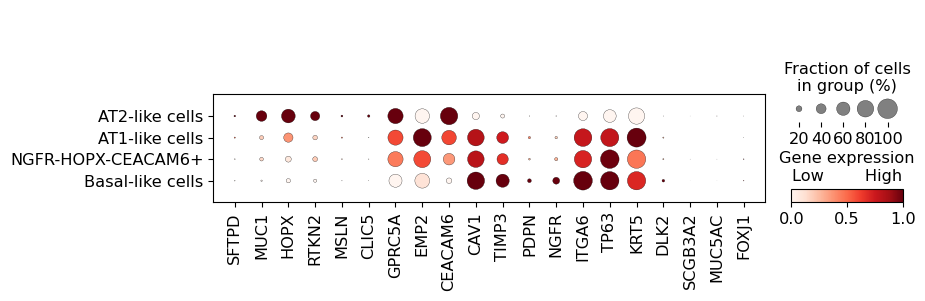

In [6]:
### Figure 5j
### Dotplot showing the expression of examples of cell type markers

rcParams['font.size']=14

genes1 = ['SFTPD', 'MUC1', 
        'HOPX', 'RTKN2', 'MSLN', 'CLIC5', 'GPRC5A', 
        'EMP2', 'CEACAM6', 
        'CAV1', 'TIMP3', 
        'PDPN', 'NGFR', 'ITGA6', 'TP63', 'KRT5',
        'DLK2', 
        'SCGB3A2', 'MUC5AC', 'FOXJ1']
sc.pl.dotplot(filtered, genes1, groupby='cell_type', 
              use_raw=True, standard_scale='var', 
              colorbar_title='Gene expression\nLow        High',
              #save='ct_dotplot.svg'
             )


In [7]:
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'
#pd.crosstab(filtered.obs['bystanders'], filtered.obs.ID).T

In [8]:
sc.pp.highly_variable_genes(filtered, n_top_genes =2000, batch_key='ID')
sc.pp.pca(filtered, n_comps=50, use_highly_variable=True, svd_solver='arpack')

sc.external.pp.harmony_integrate(filtered, 'ID', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(filtered, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')

sc.tl.umap(filtered)

2025-06-24 02:24:58,780 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-24 02:25:03,398 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-24 02:25:03,444 - harmonypy - INFO - Iteration 1 of 10
2025-06-24 02:25:06,061 - harmonypy - INFO - Iteration 2 of 10
2025-06-24 02:25:09,043 - harmonypy - INFO - Iteration 3 of 10
2025-06-24 02:25:11,743 - harmonypy - INFO - Converged after 3 iterations


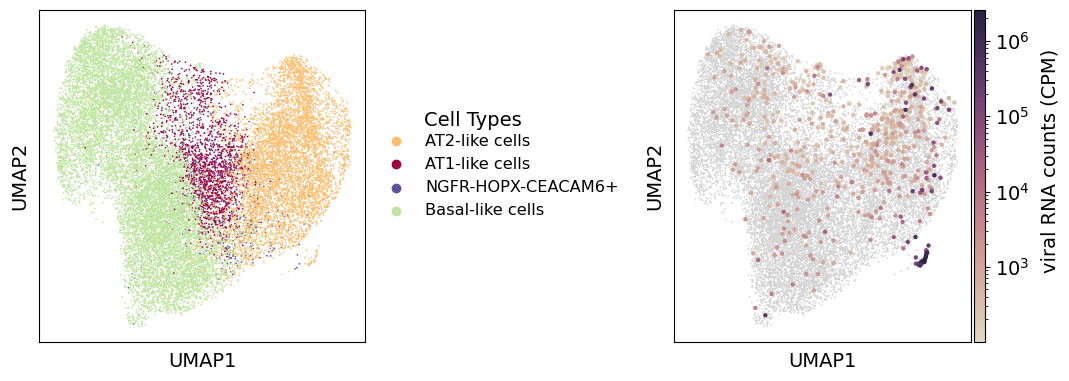

In [9]:
### Figure 5k and Figure 5l
### Umaps showing distinct cell types or SARS-CoV-2 transcripts

filtered.obs['viral_CPM'] = (filtered.obs.viral_counts +1)*1000000 / filtered.obs.total_counts

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[11,4])

filtered.uns['cell_type_colors'] = ['#fdbf6f', '#9e0142', '#5e4fa2', '#bfe5a0', ]
sc.pl.umap(filtered, color=['cell_type',], 
           legend_fontsize='small', show=False, title='', ax=ax1)
ax1.text(1.48, 0.65, 'Cell Types', fontsize='medium',
        rotation='horizontal',
        horizontalalignment='right', transform=ax1.transAxes)


palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# Plot all cells as background
sc.pl.umap(filtered, show=False, ax=ax2)
# Plot on top viral_CPM by subsetting data with viral reads >3
sc.pl.umap(filtered[(filtered.obs.viral_counts>3) ],color='viral_CPM', title='', 
            ax=ax2, cmap=palette, show=False, s=40, norm=mpl.colors.LogNorm())
ax2.text(1.3, 0.22, 'viral RNA counts (CPM)', fontsize='medium',
        rotation='vertical',
        horizontalalignment='right', transform=ax2.transAxes)

fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

In [10]:
#pd.DataFrame(filtered.obsm["X_umap"], index=filtered.obs_names).to_csv(f'{path}umap_coordinates.csv')

df = pd.DataFrame(filtered.obsm["X_umap"], index=filtered.obs_names)
df['Cell Types'] = df.index.map(filtered.obs.cell_type)
#df.to_csv(f'{path}umap_coordinates_celltype.csv', sep='\t')

df = pd.DataFrame(filtered.obsm["X_umap"], index=filtered.obs_names)
df['viral RNA counts (CPM)'] = df.index.map(filtered[(filtered.obs.viral_counts>3) ].obs.viral_CPM)
#df.to_csv(f'{path}umap_coordinates_vRNA.csv', sep='\t')

In [11]:
ress = {}
for s in filtered.obs['ID'].cat.categories:
    print(s)
    #for ct in filtered.obs.cell_type.cat.categories:
    for ct in ['AT2-like cells']:
        if ct == 'NGFR-HOPX-CEACAM6+': continue
        adata_ct = filtered[filtered.obs.cell_type == ct].copy()
#        sc.pp.filter_genes(adata_ct, min_cells=3)
        sc.tl.rank_genes_groups(adata_ct, 'ID', method='wilcoxon', reference = s, key_added = "wilcoxon")
        ress[(ct, s)] = adata_ct.uns['wilcoxon']
        
        
markers = pd.DataFrame([])
for k,results in ress.items():
    ct = k[0]
    s = k[1]
    out = np.array([[0,0,0,0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['pvals'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group]),).astype('object'),
                                     np.array([s] * len(results['names'][group]),).astype('object'),
                                     np.array([ct] * len(results['names'][group]),).astype('object'),
                                    )).T
                        ))
    out = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'pval', 'lfc', 'Condition', 'reference', 'cell_type'])
    markers = pd.concat([markers, out], axis=0, join='outer')


markers['label'] = markers['Condition']+'_'+markers['reference']
labelmap = {'24h_infected_RMC-113_24h_infected_DMSO': '24h infected, RMC-113 vs DMSO',
           '24h_uninfected_RMC-113_24h_uninfected_DMSO': '24h uninfected, RMC-113 vs DMSO',
           '24h_infected_RMC-113_24h_uninfected_RMC-113': '24h RMC-113, infected vs uninfected',
           '24h_infected_DMSO_24h_uninfected_DMSO': '24h DMSO, infected vs uninfected',
           '4h_infected_RMC-113_4h_infected_DMSO': '4h infected, RMC-113 vs DMSO',
           '4h_uninfected_RMC-113_4h_uninfected_DMSO': '4h uninfected, RMC-113 vs DMSO',
           '4h_infected_RMC-113_4h_uninfected_RMC-113': '4h RMC-113, infected vs uninfected',
           '4h_infected_DMSO_4h_uninfected_DMSO': '4h DMSO, infected vs uninfected',
           
           }
markers['label'] = markers['label'].map(labelmap)
markers = markers[~markers['label'].isna()]
markers

24h_infected_DMSO
24h_infected_RMC-113
24h_uninfected_DMSO
24h_uninfected_RMC-113
4h_infected_DMSO
4h_infected_RMC-113
4h_uninfected_DMSO
4h_uninfected_RMC-113


,Gene,scores,pval_adj,pval,lfc,Condition,reference,cell_type,label
0,GCLC,34.061676,0.0,0.0,3.234945,24h_infected_RMC-113,24h_infected_DMSO,AT2-like cells,"24h infected, RMC-113 vs DMSO"
1,TKT,24.798704,0.0,0.0,2.435072,24h_infected_RMC-113,24h_infected_DMSO,AT2-like cells,"24h infected, RMC-113 vs DMSO"
2,FTL,21.337547,0.0,0.0,3.050991,24h_infected_RMC-113,24h_infected_DMSO,AT2-like cells,"24h infected, RMC-113 vs DMSO"
3,NQO1,19.975552,0.0,0.0,3.842501,24h_infected_RMC-113,24h_infected_DMSO,AT2-like cells,"24h infected, RMC-113 vs DMSO"
4,HECTD1,19.148733,0.0,0.0,0.737912,24h_infected_RMC-113,24h_infected_DMSO,AT2-like cells,"24h infected, RMC-113 vs DMSO"
...,...,...,...,...,...,...,...,...,...
239365,DDX21,-5.824983,0.000015,0.0,-4.473413,4h_infected_RMC-113,4h_uninfected_RMC-113,AT2-like cells,"4h RMC-113, infected vs uninfected"
239366,SLC20A2,-5.85172,0.000015,0.0,-2.657176,4h_infected_RMC-113,4h_uninfected_RMC-113,AT2-like cells,"4h RMC-113, infected vs uninfected"
239367,HDAC9,-6.336817,0.000002,0.0,-5.203311,4h_infected_RMC-113,4h_uninfected_RMC-113,AT2-like cells,"4h RMC-113, infected vs uninfected"
239368,ENSG00000243004,-6.348276,0.000002,0.0,-4.782397,4h_infected_RMC-113,4h_uninfected_RMC-113,AT2-like cells,"4h RMC-113, infected vs uninfected"


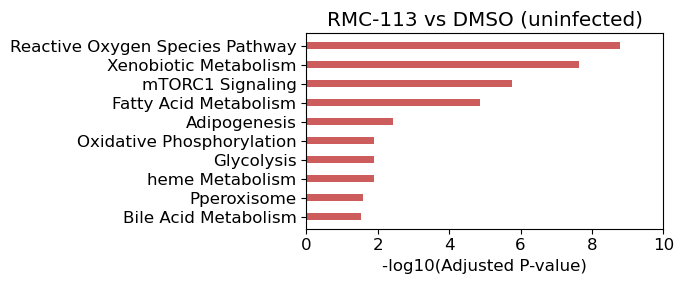

In [12]:
#### Figure 5m

rcParams['font.size']=12

ct = 'AT2-like cells'
label = '24h uninfected, RMC-113 vs DMSO'
label2plot = '24h_uninfected_RMC113_vs_DMSO'
title='RMC-113 vs DMSO (uninfected)'

go_genes = markers[(markers.cell_type.isin([ct])) & 
                   (markers.label.isin([label])) & 
                  (abs(markers.lfc)>=1.0) & (markers.pval_adj < 0.05)]
go_genes = list(go_genes.Gene.unique())


enrich_all = gp.enrichr(gene_list=go_genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     cutoff = 0.5).results


enrich_all = enrich_all[enrich_all['Adjusted P-value']<0.05]
enrich_all['Adjusted P-value'] = np.log10(enrich_all['Adjusted P-value']) * -1

df = enrich_all
df = df.reset_index().set_index('Term')['Adjusted P-value']
df = df.iloc[::-1]

width = 0.35 
h=df.shape[0]
fig = plt.subplots(figsize =(7, h*0.2+1))
p1 = plt.barh(df.index, df, width,color='indianred')
 
plt.xlabel('-log10(Adjusted P-value)')
plt.title(f'{title}')
plt.xticks(np.linspace(0,10, 6), [0, 2, 4, 6, 8, 10,]) 
plt.tight_layout()
#plt.savefig(f'{path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.svg',)
#df.to_csv(f'{path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.csv', index_col='Term')
plt.show()


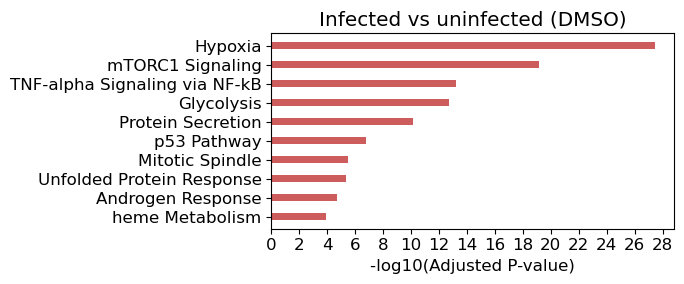

In [13]:
#### Figure 5n

ct = 'AT2-like cells'
label = '24h DMSO, infected vs uninfected'
label2plot = '24h_DMSO_infected_uninfected'
title='Infected vs uninfected (DMSO)'

go_genes = markers[(markers.cell_type.isin([ct])) & 
                   (markers.label.isin([label])) & 
                  (abs(markers.lfc)>=1.0) & (markers.pval_adj < 0.05)]
go_genes = list(go_genes.Gene.unique())


enrich_all = gp.enrichr(gene_list=go_genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     cutoff = 0.5).results


enrich_all = enrich_all[enrich_all['Adjusted P-value']<0.05]
enrich_all['Adjusted P-value'] = np.log10(enrich_all['Adjusted P-value']) * -1

df = enrich_all
df = df.reset_index().set_index('Term')['Adjusted P-value']
df = df[:10].iloc[::-1]

#ind = np.arange(N)   
width = 0.35 
h=df.shape[0]
fig = plt.subplots(figsize =(7, h*0.2+1))
p1 = plt.barh(df.index, df, width,color='indianred')
 
plt.xlabel('-log10(Adjusted P-value)')
plt.title(f'{title}')
plt.xticks(np.linspace(0,28, 15), [0, 2, 4, 6, 8, 10,12,14,16,18,20,22,24,26,28]) 
plt.tight_layout()
#plt.savefig(f'{path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.svg',)
#df.to_csv(f'{path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.csv')
plt.show()


In [14]:
marker_genes = ["MTOR", ## "mTORC1", 
                "ULK1", "ATG13",
                "RB1CC1", ## "FIP200",
                "BECN1", 
                #"ATG14", 
#                   "PIK3C3", ## "PIK3C3/VPS34", 
                'ATG7', 'ATG8', 'ATG10', 'ATG12', 'ATG16L1', 
                'MAP1LC3B', 'SQSTM1', 
                'WDFY3','NBR1', 'TAX1BP1',
                "LAMP2", "TECPR1",
                "ATG14", "STX17", "VAMP8",
                "SNAP29", "RAB7A",  
                "PLEKHM1", "GABARAP",
                "VPS11", "VPS16", "VPS18",
                "VPS33A", "VPS33B", ## "Vps33", 
                   "VPS39", "VPS41",
                ]
genes = [x.upper() for x in marker_genes if x.upper() in filtered.var_names]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]


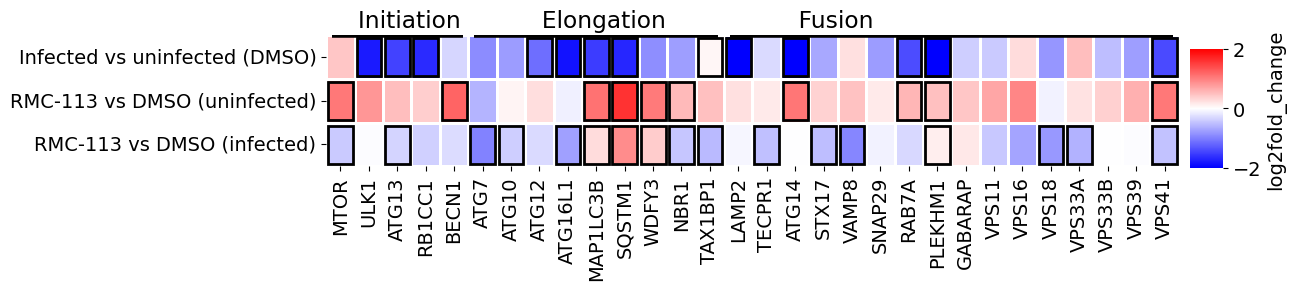

In [16]:
#### Figure 5o

rcParams['font.size']=14

fig, ax1 = plt.subplots(1,1,
                               sharex=True,
                               figsize=(11,1.7), 
                               gridspec_kw={'wspace':0.4}
                              )
cbar_ax = fig.add_axes([.91, .1, .03, .7])


#### 24h plots
ind = [0,3,2,]
tmp = markers_tmp.pivot_table(index='Gene', columns='label', values='lfc')
tmp = tmp[tmp.columns[ind]].loc[genes]
sns.heatmap(tmp.T, cmap='bwr', vmin=-2, vmax=2, ax=ax1, 
            linewidths=1,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2fold_change'})
pval = markers_tmp.pivot_table(index='Gene', columns='label', values='pval')
pval = pval[pval.columns[ind]].loc[genes]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            ax1.add_patch(
                mpl.patches.Rectangle(
                    #(j, i),
                    #1.0, 1.0,
                    (j+0.07, i+0.07),
                    0.87, 0.87,
                    edgecolor='black',
                    fill=False,
                    lw=2
                ) )
ax1.set_yticklabels(['Infected vs uninfected (DMSO)', 'RMC-113 vs DMSO (uninfected)', 'RMC-113 vs DMSO (infected)',],
                   fontsize=14)
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.hlines(y=0., xmin=0.2, xmax=4.8, linewidth=4, color='k')
ax1.hlines(y=0., xmin=5.2, xmax=13.8, linewidth=4, color='k')
ax1.hlines(y=0., xmin=14.2, xmax=29.8, linewidth=4, color='k')

title = 'Initiation           Elongation                  Fusion                                     '
ax1.set_title(title)


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_24h_linewidth1_3_new_updated.svg', format="svg")
#tmp.to_csv(f'{path}heatmap_24h.csv', sep='\t')
#pval.to_csv(f'{path}heatmap_24h_pval.csv', sep='\t')
plt.show()


In [17]:
def plot_gene_expression(filtered, ct, gene):
    rcParams['font.size']=8
    
    
    adata_tmp = filtered[filtered.obs.cell_type == ct].copy()
    df = adata_tmp.obs[['ID', 'cell_type']]
    df[gene] = adata_tmp[:,gene].X.A
    df.index.name = 'cellID'
    df = df.reset_index()
    df['newID'] = [' '.join(x.split('_')[1:]) for x in df.ID]


    pairs = [
    ['uninfected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'infected DMSO'],
    ['infected DMSO', 'uninfected DMSO'],
#    ['infected RMC-113', 'uninfected DMSO'],
    ]
    order = ['uninfected DMSO', 
         'uninfected RMC-113', 
         'infected DMSO', 
         'infected RMC-113', 
        ]
    cmap = sns.color_palette('Set2', 4)
    hue_plot_params = {'data': df.dropna(),
                   'x' : 'newID', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black', 'linewidth':0.5},
                   'capprops' : {'color':'none'},
                   'palette' : ['silver', 'whitesmoke', 'silver', 'whitesmoke',], 
                   'width' : 0.8, 
                   'showfliers': False}

    fig, ax = plt.subplots(figsize=[2.5, 3])
    sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

    empty_box=False
    if empty_box:
        for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor((0, 0, 0, 0))
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                ax.lines[j].set_color(color)

            
    sns.stripplot(data = df.dropna(), 
              x = 'newID', y = gene, order=order, zorder=10,
             palette=cmap,  s=2, ax=ax, edgecolor='black', linewidth=0.3, dodge=True).legend('')


    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.new_plot(ax, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=False, show_test_name=False).apply_and_annotate()

    ax.legend(loc=(1.05, 0.5))
    ax.set_ylabel(f'{gene} (log2(CPM+1))', fontsize='medium')
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels([x.split()[1] for x in labels], rotation=45, fontsize='medium')
    ax.set_xlabel('Uninfected           Infected    ', fontsize='medium')
    ax.set_axisbelow(True)
    #ax.grid(True)


    #plt.savefig(f'{figure_path}{gene}_allpvals.svg')
    fig.tight_layout()
    #plt.savefig(f'{figure_path}{gene}_allpvals.png')
    plt.show()
    return(fig, ax)


In [18]:
filtered =filtered[(filtered.obs.high_quality=='True') & 
               #(adata.obs.cell_type.isin(['AT2-like cells'])) &
                (filtered.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113']))
               ]

ct = 'AT2-like cells'
adata_tmp = filtered[filtered.obs.cell_type == ct].copy()
df = adata_tmp.obs[['ID', 'cell_type']]

gene = ['MAP1LC3B','SQSTM1','PLEKHM1']
df[gene] = adata_tmp[:,gene].X.A
df.index.name = 'cellID'
df = df.reset_index()
df['newID'] = [' '.join(x.split('_')[1:]) for x in df.ID]
#df.to_csv(f'{path}gene_expression.csv', sep='\t')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


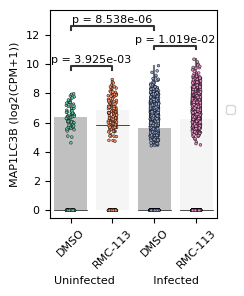

In [21]:
#### Fig 5p

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'MAP1LC3B')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


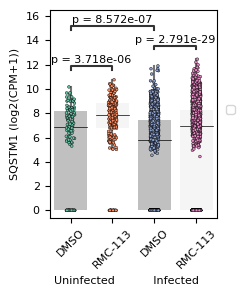

In [22]:
#### Fig 5q

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'SQSTM1')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


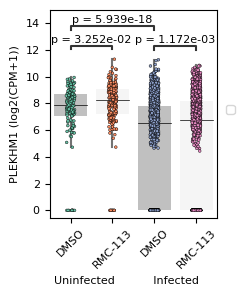

In [23]:
#### Fig 5r

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'PLEKHM1')